In [1]:
import import_ipynb
import pandas as pd
from APS_system_package.data_clean import train_data_clean, test_data_clean, test_data_clean_v2
from APS_system_package.preprocessing import *
from APS_system_package.logistic_regressions import *
from APS_system_package.performance_measure import *
import seaborn as sns
sns.set()
import time

importing Jupyter notebook from C:\Users\shuxg\Desktop\EIT\Proj 4 - Logistic\APS_system_package\data_clean.ipynb
importing Jupyter notebook from C:\Users\shuxg\Desktop\EIT\Proj 4 - Logistic\APS_system_package\preprocessing.ipynb
importing Jupyter notebook from C:\Users\shuxg\Desktop\EIT\Proj 4 - Logistic\APS_system_package\logistic_regressions.ipynb
importing Jupyter notebook from C:\Users\shuxg\Desktop\EIT\Proj 4 - Logistic\APS_system_package\performance_measure.ipynb


## Load Ori Dataset

In [2]:
df_trn = train_data_clean('train.csv', 'median')
df_val = test_data_clean('test.csv', 'train.csv', 'median')

Nan: 0
Nan: 0
Nan: 0


## Remove Columns

In [3]:
df_pos = df_trn[df_trn['class'] == 1]
df_neg = df_trn[df_trn['class'] == 0]

In [4]:
cols = []
pos_values = []
neg_values = []
for col in df_trn.columns:
    pos_zeros = (df_pos[col] == 0).sum()
    neg_zeros = (df_neg[col] == 0).sum()
    if pos_zeros/df_pos.shape[0] > 0.85 and neg_zeros/df_neg.shape[0] > 0.8:
        cols.append(col)
        pos_values.append(pos_zeros/df_pos.shape[0])
        neg_values.append(neg_zeros/df_neg.shape[0])

Text(0.5, 0.98, 'Zeros Ratio')

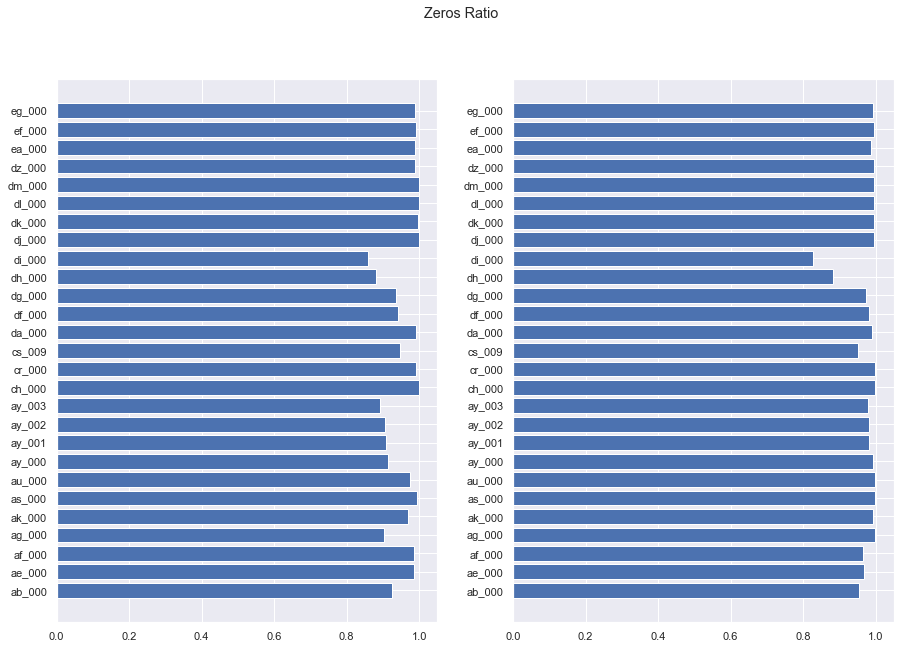

In [5]:
plt.figure(figsize = (15,10))
plt.subplot(121)
plt.barh(cols, pos_values)
plt.subplot(122)
plt.barh(cols, neg_values)
plt.suptitle('Zeros Ratio')

In [6]:
df_trn = df_trn.drop(cols, axis = 1)
df_val = df_val.drop(cols, axis = 1)
print(df_trn.shape)
print(df_val.shape)

(60000, 144)
(16000, 144)


## Preprocess

**convert dataframe to numpy**

In [7]:
data_trn = df_trn.to_numpy()
data_val = df_val.to_numpy()

X_trn, y_trn = data_trn[:, 1:], data_trn[:, 0]
X_val, y_val = data_val[:, 1:], data_val[:, 0]

normalizer = MaxMinNormalization(X_trn)

X_trn = normalizer.fit(X_trn)
X_val = normalizer.fit(X_val)

**oversampling train data (only in positive case)**

In [8]:
positive_case = X_trn[y_trn == 1]
positive_labl = y_trn[y_trn == 1]
X_pos_oversample = positive_case.copy()
y_pos_oversample = positive_labl.copy()
M = 59
for m in range(M):
    X_pos_oversample = np.vstack((X_pos_oversample, positive_case))
    y_pos_oversample = np.hstack((y_pos_oversample, positive_labl))
X_POS = np.hstack((X_pos_oversample, y_pos_oversample.reshape(-1, 1)))

In [9]:
Data_oversample = np.vstack((X_POS, np.hstack((X_trn, y_trn.reshape(-1, 1)))))

**randomly shuffle oversampled data**

In [10]:
np.random.shuffle(Data_oversample)
X_oversample, y_oversample = X_trn, y_trn = Data_oversample[:, :-1], Data_oversample[:, -1]

In [11]:
X_oversample.shape

(120000, 143)

## Model

In [12]:
class GenLogisticRegression():
    
    def __init__(self, X, y):        
        N, D = X.shape
        K = len(np.unique(y))
        self.w = np.random.randn(D, K)
        self.b = np.random.randn(K)
    
    def fit(self, X_trn, y_trn,
            X_val, y_val,
            lr = 1e-1, epochs = 1e3,
            show_curve = False, verbose = 0):
        # set them to integer
        epochs = int(epochs)
        y_trn = y_trn.astype(int)
        y_val = y_val.astype(int)
        # class number
        K = len(np.unique(y_trn))
        N, D = X_trn.shape
        Y_trn = indices_to_one_hot(y_trn, K).astype(int)
        Y_val = indices_to_one_hot(y_val, K).astype(int)
        
        J_trn = np.zeros(epochs) # train loss
        J_val = np.zeros(epochs) # validation loss
        
        for epoch in range(epochs): # start to train
            # get probability for cross entropy
            P_hat = self.__forward__(X_trn)
            # record training process
            J_trn[epoch] = cross_entropy(Y_trn, P_hat)
            J_val[epoch] = cross_entropy(Y_val, self.__forward__(X_val))
            # weights update
            self.w -= lr*(1/N)*X_trn.T@(P_hat - Y_trn)
            self.b -= lr*(1/N)*np.sum(P_hat - Y_trn, axis = 0)
            # print progress
            if verbose == 1:
                if epoch % 50 == 0:
                    print('Epoch: {}, train error: {:.4f}, validation error: {:.4f}'.\
                          format(epoch, J_trn[epoch], J_val[epoch]))
                    print(accuracy(y_trn, self.predict(X_trn)))
            else:
                pass
        # plot curve
        if show_curve:
            plt.figure(figsize = (15, 6))
            # train plot
            plt.subplot(121); plt.plot(J_trn)
            plt.xlabel('epochs'); plt.ylabel('$\mathcal{J}$')
            plt.title('Training Curve', fontsize = 15)
            # valid plot
            plt.subplot(122); plt.plot(J_val)
            plt.xlabel('epochs'); plt.ylabel('$\mathcal{J}$')
            plt.title('Validation Curve', fontsize = 15)
        # return training process
        return {'J_trn': J_trn, 'J_val': J_val}
    
    def __forward__(self, X):
        return softmax(X@self.w + self.b)
        
    def predict(self, X):
        return np.argmax(self.__forward__(X), axis = 1)

'''Assistant Function'''
def accuracy(y, y_hat):
    return np.mean(y == y_hat)

def softmax(h):
    return (np.exp(h.T)/np.sum(np.exp(h), axis = 1)).T

def indices_to_one_hot(data, nb_classes):
    targets = np.array(data).reshape(-1)
    return np.eye(nb_classes)[targets]


def cross_entropy(y, P_hat):
    return -(1/len(y)) * np.sum(np.sum(y*np.log(P_hat), axis = 1), axis = 0)

**build model**

In [13]:
model = GenLogisticRegression(X_oversample, y_oversample)
J_trn = np.zeros(1)
J_val = np.zeros(1)
pos_acc_trn = np.zeros(1)
neg_acc_trn = np.zeros(1)
pos_acc_val = np.zeros(1)
neg_acc_val = np.zeros(1)

In [15]:
model.w = np.load('ori_delcol_GenLogReg_weights.npy')
model.b = np.load('ori_delcol_GenLogReg_biases.npy')

**train model**

In [21]:
start = time.time()
for epoch in range(1):
    J = model.fit(X_oversample, y_oversample, X_val, y_val, lr = 1e-2, epochs = 1, show_curve = False)
    # save loss
    J_trn = np.hstack((J_trn, J['J_trn']))
    J_val = np.hstack((J_val, J['J_val']))
    # save accs
    pos_acc_trn = np.hstack((pos_acc_trn, accuracy(model.predict(X_trn[y_trn == 1]), y_trn[y_trn == 1])))
    neg_acc_trn = np.hstack((neg_acc_trn, accuracy(model.predict(X_trn[y_trn == 0]), y_trn[y_trn == 0])))
    pos_acc_val = np.hstack((pos_acc_val, accuracy(model.predict(X_val[y_val == 1]), y_val[y_val == 1])))
    neg_acc_val = np.hstack((neg_acc_val, accuracy(model.predict(X_val[y_val == 0]), y_val[y_val == 0])))
    # print process
    if epoch % 200 == 0:
        end = time.time() - start
        print('EPOCH: {}'.format(epoch))
        print('trn loss: {:.5f}, val loss {:.5f}'.format(J_trn[-1], J_val[-1]))
        print('trn pos acc: {:.2f}, trn neg acc {:.2f}'.format(pos_acc_trn[-1], neg_acc_trn[-1]))
        print('val pos acc: {:.2f}, val neg acc {:.2f}'.format(pos_acc_val[-1], neg_acc_val[-1]))
        print('time: {:.2f} s'.format((end)))
        start = time.time()
        cost1 = (1 - pos_acc_trn[-1])*1000*500 + (1 - neg_acc_trn[-1])*59000*10
        cost2 = (1 - pos_acc_val[-1])*375*500 + (1 - neg_acc_val[-1])*15625*10
        print('trn cost: {:.0f}, val cost: {:.0f}'.format(cost1, cost2))
        print('----------------------------------------')
    if pos_acc_val[-1] >= 0.96:
        file_weights = 'ori_GenLogReg_weights'
        file_biases  = 'ori_GenLogReg_biases'
        np.save(file_weights, model.w)
        np.save(file_biases,  model.b)
        print('--------------SAVED !!!----------------')
        break

EPOCH: 0
trn loss: 0.18575, val loss 0.19808
trn pos acc: 0.93, trn neg acc 0.96
val pos acc: 0.91, val neg acc 0.97
time: 0.25 s
trn cost: 57570, val cost: 22910
----------------------------------------


In [17]:
print('trn cost: {:.0f}, val cost: {:.0f}'.format(cost1, cost2))

trn cost: 57570, val cost: 22910


## Result
**the final train cost: 57570** <br>
**the final test cost:  22910**

#### save weights for later training

In [18]:
file_weights = 'ori_delcol_GenLogReg_weights'
file_biases  = 'ori_delcol_GenLogReg_biases'

In [19]:
np.save(file_weights, model.w)
np.save(file_biases,  model.b)

**plots**

Text(0.5, 1.0, 'Loss')

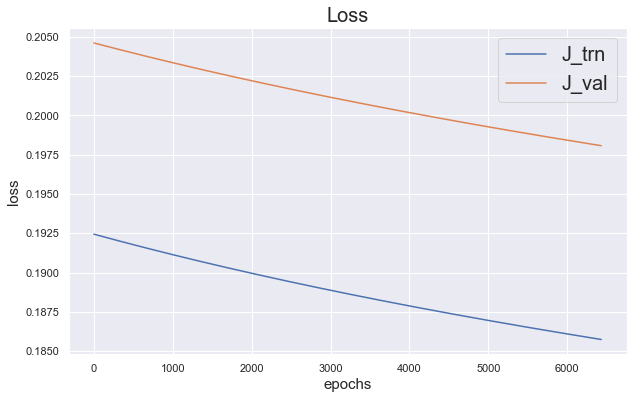

In [20]:
plt.figure(figsize = (10, 6))
plt.plot(J_trn[1:])
plt.plot(J_val[1:])
plt.xlabel('epochs', fontsize = 15)
plt.ylabel('loss', fontsize = 15)
plt.legend(['J_trn', 'J_val'], fontsize = 20)
plt.title('Loss', fontsize = 20)

Text(0.5, 1.0, 'Trn Acc')

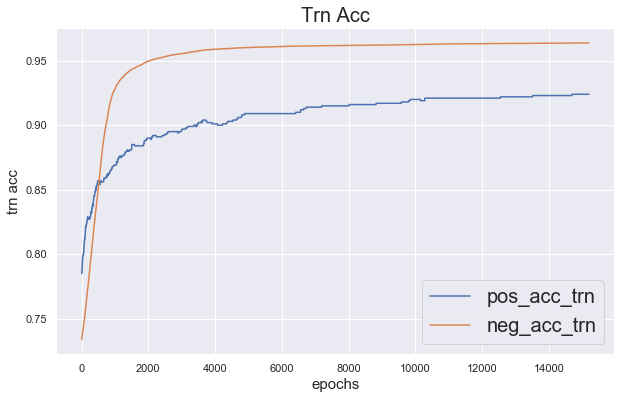

In [39]:
plt.figure(figsize = (10, 6))
plt.plot(pos_acc_trn[1:])
plt.plot(neg_acc_trn[1:])
plt.xlabel('epochs', fontsize = 15)
plt.ylabel('trn acc', fontsize = 15)
plt.legend(['pos_acc_trn', 'neg_acc_trn'], fontsize = 20)
plt.title('Trn Acc', fontsize = 20)

Text(0.5, 1.0, 'Val Acc')

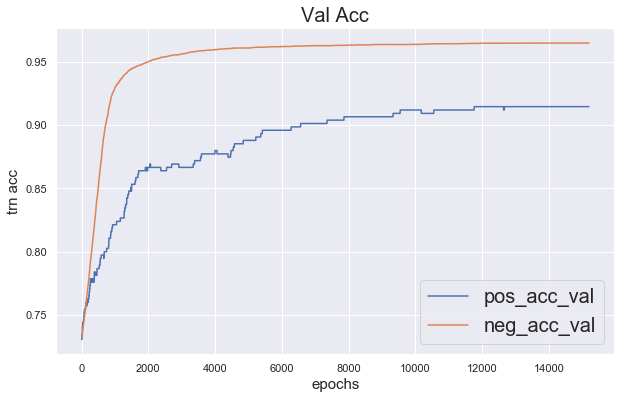

In [40]:
plt.figure(figsize = (10, 6))
plt.plot(pos_acc_val[1:])
plt.plot(neg_acc_val[1:])
plt.xlabel('epochs', fontsize = 15)
plt.ylabel('trn acc', fontsize = 15)
plt.legend(['pos_acc_val', 'neg_acc_val'], fontsize = 20)
plt.title('Val Acc', fontsize = 20)